In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


In [2]:
# Load the dataset
df = pd.read_csv('Churn_Modelling.csv')

print(f"Dataset shape: {df.shape}")
print(f"Churn rate: {df['Exited'].mean():.2%}")
print(f"\nFirst few rows:")
df.head()


Dataset shape: (10000, 14)
Churn rate: 20.37%

First few rows:


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Exploratory Data Analysis (EDA)


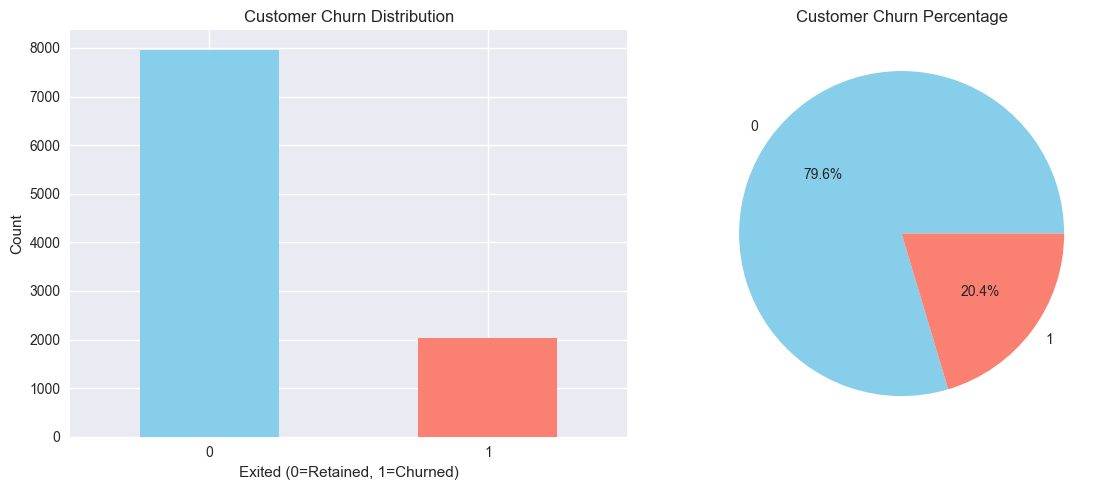

In [3]:
# Visualize target variable distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
df['Exited'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Customer Churn Distribution')
plt.xlabel('Exited (0=Retained, 1=Churned)')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
df['Exited'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['skyblue', 'salmon'])
plt.title('Customer Churn Percentage')
plt.ylabel('')

plt.tight_layout()
plt.show()


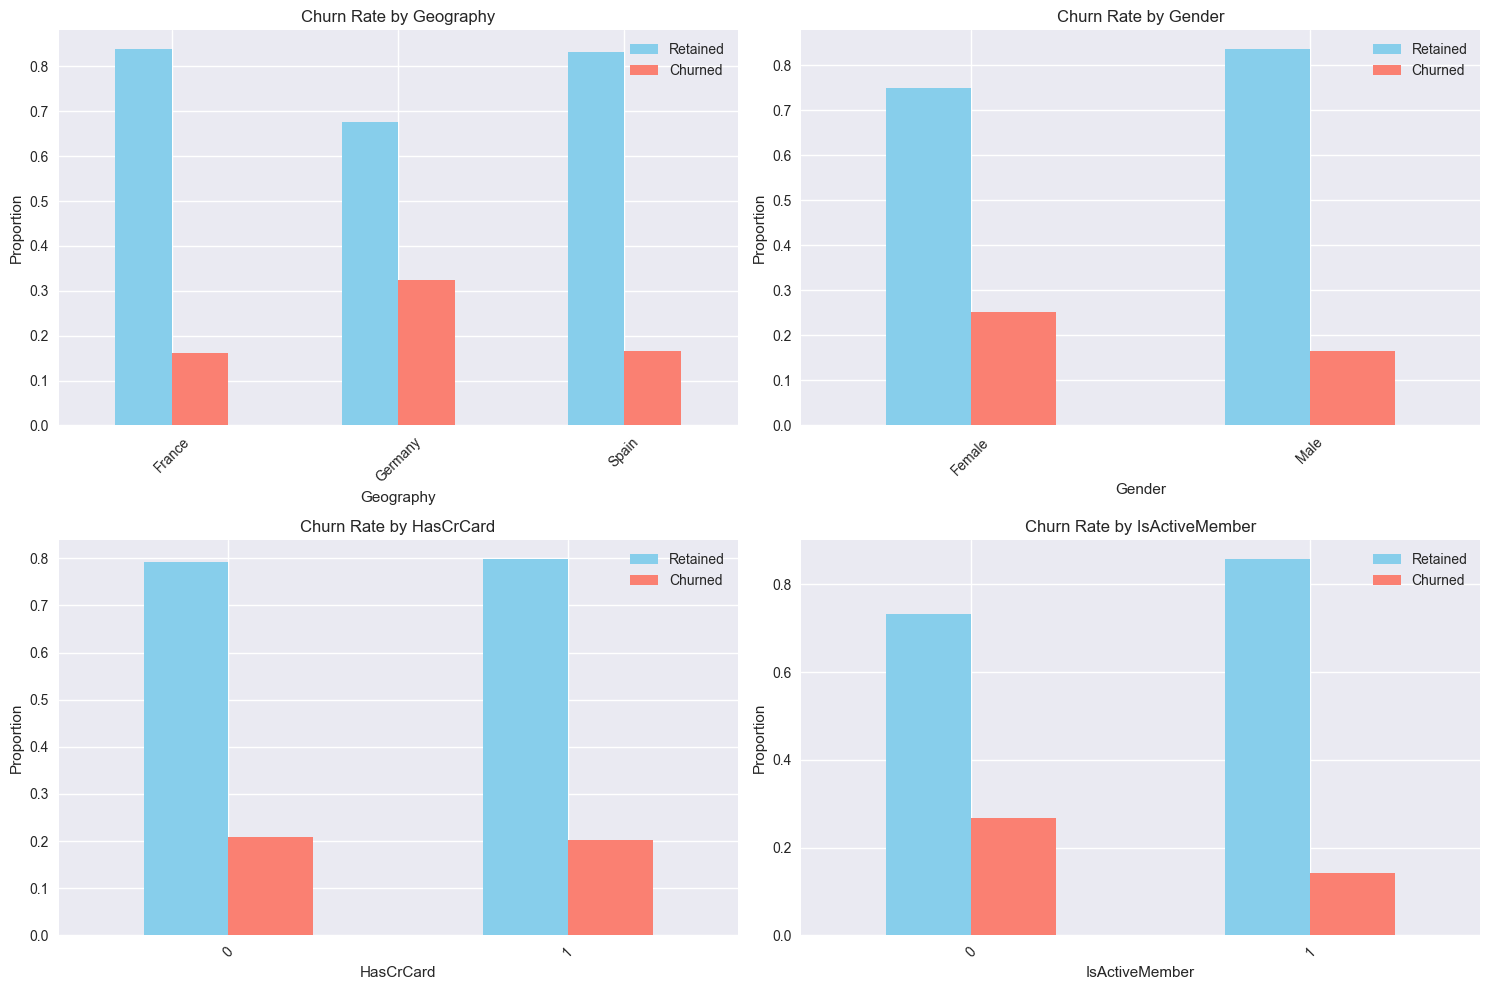

In [4]:
# Analyze categorical variables
categorical_vars = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for i, var in enumerate(categorical_vars):
    # Create crosstab for churn analysis
    crosstab = pd.crosstab(df[var], df['Exited'], normalize='index')
    
    # Plot
    crosstab.plot(kind='bar', ax=axes[i], color=['skyblue', 'salmon'])
    axes[i].set_title(f'Churn Rate by {var}')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Proportion')
    axes[i].legend(['Retained', 'Churned'])
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


## Data Preprocessing and Feature Engineering


In [5]:
# Create a copy of the dataset for preprocessing
df_processed = df.copy()

# Remove unnecessary columns
df_processed = df_processed.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)



In [6]:
# Encode categorical variables
le_geography = LabelEncoder()
le_gender = LabelEncoder()

df_processed['Geography'] = le_geography.fit_transform(df_processed['Geography'])
df_processed['Gender'] = le_gender.fit_transform(df_processed['Gender'])

print("Encoded categorical variables:")
print(f"Geography mapping: {dict(zip(le_geography.classes_, le_geography.transform(le_geography.classes_)))}")
print(f"Gender mapping: {dict(zip(le_gender.classes_, le_gender.transform(le_gender.classes_)))}")

print("\nFirst few rows after encoding:")
df_processed.head()


Encoded categorical variables:
Geography mapping: {'France': np.int64(0), 'Germany': np.int64(1), 'Spain': np.int64(2)}
Gender mapping: {'Female': np.int64(0), 'Male': np.int64(1)}

First few rows after encoding:


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,0,0,42,2,0.00,1,1,1,101348.88,1
1,608,2,0,41,1,83807.86,1,0,1,112542.58,0
2,502,0,0,42,8,159660.80,3,1,0,113931.57,1
3,699,0,0,39,1,0.00,2,0,0,93826.63,0
4,850,2,0,43,2,125510.82,1,1,1,79084.10,0


In [7]:
# Feature engineering: Create new features
# Age groups
df_processed['AgeGroup'] = pd.cut(df_processed['Age'], 
                                 bins=[0, 30, 40, 50, 100], 
                                 labels=['Young', 'Middle', 'Senior', 'Elderly'])
df_processed['AgeGroup'] = LabelEncoder().fit_transform(df_processed['AgeGroup'])

# Balance to Salary ratio
df_processed['BalanceToSalaryRatio'] = df_processed['Balance'] / (df_processed['EstimatedSalary'] + 1)

# Credit Score groups
df_processed['CreditScoreGroup'] = pd.cut(df_processed['CreditScore'], 
                                         bins=[0, 600, 700, 800, 1000], 
                                         labels=['Poor', 'Fair', 'Good', 'Excellent'])
df_processed['CreditScoreGroup'] = LabelEncoder().fit_transform(df_processed['CreditScoreGroup'])

# Tenure groups
df_processed['TenureGroup'] = pd.cut(df_processed['Tenure'], 
                                    bins=[0, 2, 5, 8, 10], 
                                    labels=['New', 'Short', 'Medium', 'Long'])
df_processed['TenureGroup'] = LabelEncoder().fit_transform(df_processed['TenureGroup'])

print(f"\nNew dataset shape: {df_processed.shape}")
print("\nNew features:")
print(df_processed[['AgeGroup', 'BalanceToSalaryRatio', 'CreditScoreGroup', 'TenureGroup']].head())



New dataset shape: (10000, 15)

New features:
   AgeGroup  BalanceToSalaryRatio  CreditScoreGroup  TenureGroup
0         2              0.000000                 1            2
1         2              0.744670                 1            2
2         2              1.401362                 3            1
3         1              0.000000                 1            2
4         2              1.587035                 0            2


In [8]:
# Prepare features and target
X = df_processed.drop('Exited', axis=1)
y = df_processed['Exited']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeature columns: {list(X.columns)}")


Features shape: (10000, 14)
Target shape: (10000,)

Feature columns: ['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'AgeGroup', 'BalanceToSalaryRatio', 'CreditScoreGroup', 'TenureGroup']


In [9]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Training set churn rate: {y_train.mean():.2%}")
print(f"Test set churn rate: {y_test.mean():.2%}")


Training set size: 8000
Test set size: 2000
Training set churn rate: 20.38%
Test set churn rate: 20.35%


In [10]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features scaled using StandardScaler")
print(f"Scaled training set shape: {X_train_scaled.shape}")
print(f"Scaled test set shape: {X_test_scaled.shape}")


Features scaled using StandardScaler
Scaled training set shape: (8000, 14)
Scaled test set shape: (2000, 14)


## Model Building and Training


In [11]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42, n_estimators=100)
}

# Train models and store results
model_results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train the model
    model.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    # Cross-validation score
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='roc_auc')
    
    # Store results
    model_results[name] = {
        'model': model,
        'predictions': y_pred,
        'probabilities': y_pred_proba,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std()
    }
    
    print(f"{name} - Accuracy: {accuracy:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")
    print(f"Cross-validation AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")



Training Logistic Regression...
Logistic Regression - Accuracy: 0.8030, F1: 0.2481, AUC: 0.7737
Cross-validation AUC: 0.7538 (+/- 0.0242)

Training Random Forest...
Random Forest - Accuracy: 0.8605, F1: 0.5550, AUC: 0.8423
Cross-validation AUC: 0.8504 (+/- 0.0176)

Training Gradient Boosting...
Gradient Boosting - Accuracy: 0.8655, F1: 0.5881, AUC: 0.8683
Cross-validation AUC: 0.8606 (+/- 0.0217)


## Model Performance and Analysis Comparison


In [12]:
# Create performance comparison DataFrame
performance_df = pd.DataFrame({
    'Model': list(model_results.keys()),
    'Accuracy': [model_results[name]['accuracy'] for name in model_results.keys()],
    'Precision': [model_results[name]['precision'] for name in model_results.keys()],
    'Recall': [model_results[name]['recall'] for name in model_results.keys()],
    'F1-Score': [model_results[name]['f1'] for name in model_results.keys()],
    'AUC': [model_results[name]['auc'] for name in model_results.keys()],
    'CV-AUC-Mean': [model_results[name]['cv_mean'] for name in model_results.keys()],
    'CV-AUC-Std': [model_results[name]['cv_std'] for name in model_results.keys()]
})

print("Model Performance Comparison:")
print(performance_df.round(4))


Model Performance Comparison:
                 Model  Accuracy  Precision  Recall  F1-Score     AUC  \
0  Logistic Regression    0.8030     0.5556  0.1597    0.2481  0.7737   
1        Random Forest    0.8605     0.7909  0.4275    0.5550  0.8423   
2    Gradient Boosting    0.8655     0.7805  0.4717    0.5881  0.8683   

   CV-AUC-Mean  CV-AUC-Std  
0       0.7538      0.0121  
1       0.8504      0.0088  
2       0.8606      0.0108  


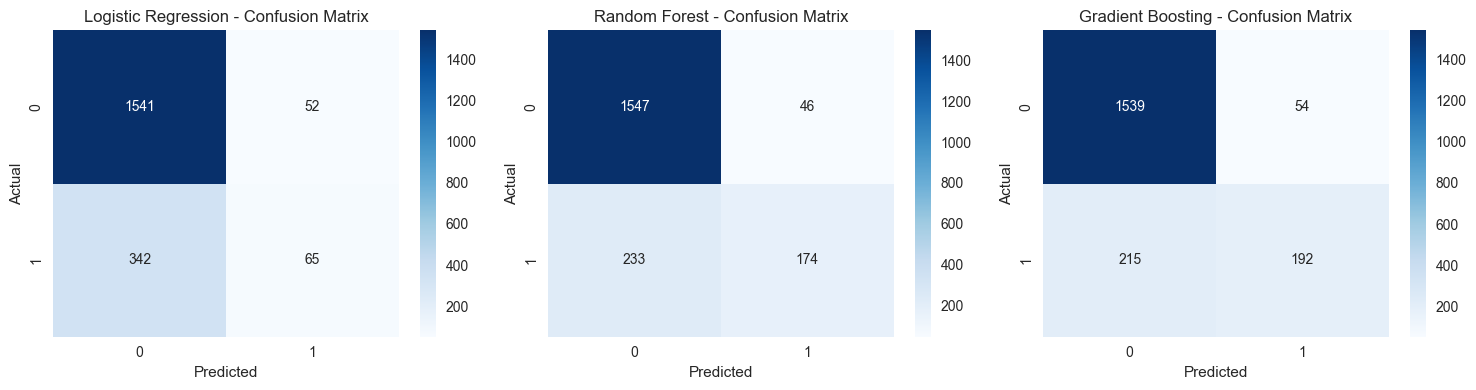

In [13]:
# Confusion matrices for all models
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, (name, results) in enumerate(model_results.items()):
    cm = confusion_matrix(y_test, results['predictions'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'{name} - Confusion Matrix')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.show()


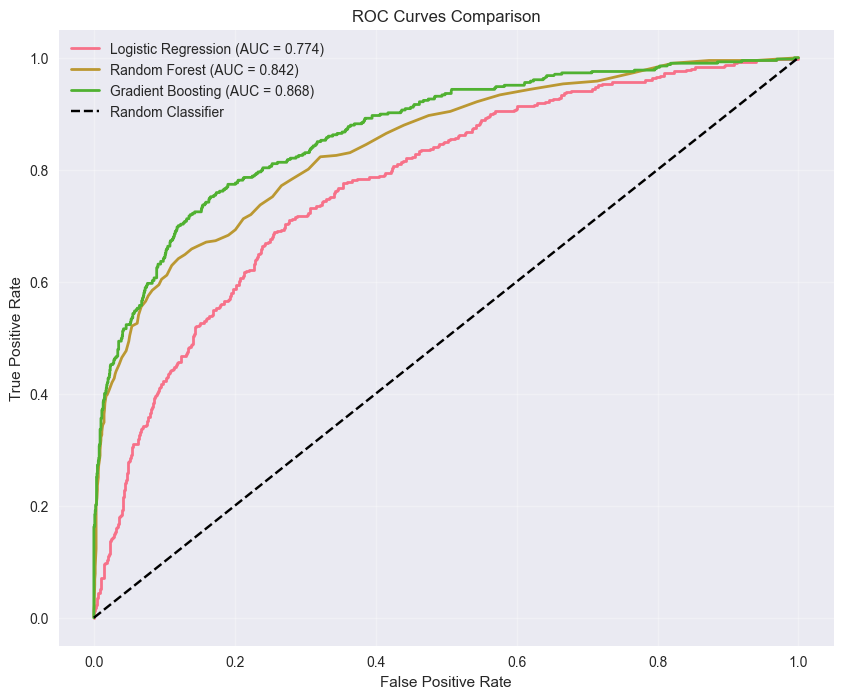

In [14]:
# ROC Curves for all models
plt.figure(figsize=(10, 8))

for name, results in model_results.items():
    fpr, tpr, _ = roc_curve(y_test, results['probabilities'])
    plt.plot(fpr, tpr, label=f'{name} (AUC = {results["auc"]:.3f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [15]:
# Final model performance summary
print("CUSTOMER CHURN PREDICTION - FINAL RESULTS")

print(f"\nDataset Information:")
print(f"- Total customers: {len(df):,}")
print(f"- Churned customers: {df['Exited'].sum():,} ({df['Exited'].mean():.1%})")
print(f"- Retained customers: {(df['Exited'] == 0).sum():,} ({(df['Exited'] == 0).mean():.1%})")

print(f"\nModel Performance Summary:")
for name, results in model_results.items():
    print(f"\n{name}:")
    print(f"  - Accuracy: {results['accuracy']:.3f}")
    print(f"  - Precision: {results['precision']:.3f}")
    print(f"  - Recall: {results['recall']:.3f}")
    print(f"  - F1-Score: {results['f1']:.3f}")
    print(f"  - AUC: {results['auc']:.3f}")

# Find best model
best_model_name = max(model_results.keys(), key=lambda x: model_results[x]['auc'])
print(f"\nBest Model: {best_model_name}")
print(f"Best AUC Score: {model_results[best_model_name]['auc']:.3f}")


CUSTOMER CHURN PREDICTION - FINAL RESULTS

Dataset Information:
- Total customers: 10,000
- Churned customers: 2,037 (20.4%)
- Retained customers: 7,963 (79.6%)

Model Performance Summary:

Logistic Regression:
  - Accuracy: 0.803
  - Precision: 0.556
  - Recall: 0.160
  - F1-Score: 0.248
  - AUC: 0.774

Random Forest:
  - Accuracy: 0.861
  - Precision: 0.791
  - Recall: 0.428
  - F1-Score: 0.555
  - AUC: 0.842

Gradient Boosting:
  - Accuracy: 0.866
  - Precision: 0.780
  - Recall: 0.472
  - F1-Score: 0.588
  - AUC: 0.868

Best Model: Gradient Boosting
Best AUC Score: 0.868


In [16]:
def predict_churn_direct(customer_data, model_name='Random Forest'):
    
    # Get the trained model from our results
    if model_name not in model_results:
        raise ValueError(f"Model '{model_name}' not found. Available models: {list(model_results.keys())}")
    
    model = model_results[model_name]['model']
    
    # Create DataFrame from input data
    df_input = pd.DataFrame([customer_data])
    
    # Encode categorical variables (using the same encoders from training)
    df_input['Geography'] = le_geography.transform(df_input['Geography'])
    df_input['Gender'] = le_gender.transform(df_input['Gender'])
    
    # Feature engineering (same as training)
    df_input['AgeGroup'] = pd.cut(df_input['Age'], 
                                 bins=[0, 30, 40, 50, 100], 
                                 labels=['Young', 'Middle', 'Senior', 'Elderly'])
    df_input['AgeGroup'] = LabelEncoder().fit_transform(df_input['AgeGroup'])
    
    df_input['BalanceToSalaryRatio'] = df_input['Balance'] / (df_input['EstimatedSalary'] + 1)
    
    df_input['CreditScoreGroup'] = pd.cut(df_input['CreditScore'], 
                                         bins=[0, 600, 700, 800, 1000], 
                                         labels=['Poor', 'Fair', 'Good', 'Excellent'])
    df_input['CreditScoreGroup'] = LabelEncoder().fit_transform(df_input['CreditScoreGroup'])
    
    df_input['TenureGroup'] = pd.cut(df_input['Tenure'], 
                                    bins=[0, 2, 5, 8, 10], 
                                    labels=['New', 'Short', 'Medium', 'Long'])
    df_input['TenureGroup'] = LabelEncoder().fit_transform(df_input['TenureGroup'])
    
    # Scale features (using the same scaler from training)
    X_scaled = scaler.transform(df_input)
    
    # Make prediction
    churn_probability = model.predict_proba(X_scaled)[0, 1]
    churn_prediction = model.predict(X_scaled)[0]
    
    return {
        'model_used': model_name,
        'churn_probability': churn_probability,
        'churn_prediction': churn_prediction,
        'risk_level': 'High' if churn_probability > 0.7 else 'Medium' if churn_probability > 0.4 else 'Low',
        'confidence': 'High' if churn_probability > 0.8 or churn_probability < 0.2 else 'Medium'
    }

# Example 1: High-risk customer
high_risk_customer = {
    'CreditScore': 450,
    'Geography': 'Germany',
    'Gender': 'Male',
    'Age': 65,
    'Tenure': 1,
    'Balance': 150000,
    'NumOfProducts': 4,
    'HasCrCard': 0,
    'IsActiveMember': 0,
    'EstimatedSalary': 50000
}

print("\n1. HIGH-RISK CUSTOMER:")
print(f"Customer profile: {high_risk_customer}")
result = predict_churn_direct(high_risk_customer, 'Random Forest')
print(f"Model used: {result['model_used']}")
print(f"Churn probability: {result['churn_probability']:.3f}")
print(f"Prediction: {'WILL CHURN' if result['churn_prediction'] == 1 else 'WILL RETAIN'}")
print(f"Risk level: {result['risk_level']}")
print(f"Confidence: {result['confidence']}")

# Example 2: Low-risk customer
low_risk_customer = {
    'CreditScore': 750,
    'Geography': 'France',
    'Gender': 'Female',
    'Age': 35,
    'Tenure': 8,
    'Balance': 50000,
    'NumOfProducts': 2,
    'HasCrCard': 1,
    'IsActiveMember': 1,
    'EstimatedSalary': 120000
}

print("\n2. LOW-RISK CUSTOMER:")
print(f"Customer profile: {low_risk_customer}")
result = predict_churn_direct(low_risk_customer, 'Random Forest')
print(f"Model used: {result['model_used']}")
print(f"Churn probability: {result['churn_probability']:.3f}")
print(f"Prediction: {'WILL CHURN' if result['churn_prediction'] == 1 else 'WILL RETAIN'}")
print(f"Risk level: {result['risk_level']}")
print(f"Confidence: {result['confidence']}")

# Example 3: Compare all models for the same customer
print("\n3. MODEL COMPARISON FOR SAME CUSTOMER:")
test_customer = {
    'CreditScore': 600,
    'Geography': 'Spain',
    'Gender': 'Male',
    'Age': 45,
    'Tenure': 3,
    'Balance': 80000,
    'NumOfProducts': 2,
    'HasCrCard': 1,
    'IsActiveMember': 0,
    'EstimatedSalary': 90000
}

print(f"Customer profile: {test_customer}")
for model_name in model_results.keys():
    result = predict_churn_direct(test_customer, model_name)
    print(f"\n{model_name}:")
    print(f"  - Churn probability: {result['churn_probability']:.3f}")
    print(f"  - Prediction: {'WILL CHURN' if result['churn_prediction'] == 1 else 'WILL RETAIN'}")
    print(f"  - Risk level: {result['risk_level']}")



1. HIGH-RISK CUSTOMER:
Customer profile: {'CreditScore': 450, 'Geography': 'Germany', 'Gender': 'Male', 'Age': 65, 'Tenure': 1, 'Balance': 150000, 'NumOfProducts': 4, 'HasCrCard': 0, 'IsActiveMember': 0, 'EstimatedSalary': 50000}
Model used: Random Forest
Churn probability: 0.870
Prediction: WILL CHURN
Risk level: High
Confidence: High

2. LOW-RISK CUSTOMER:
Customer profile: {'CreditScore': 750, 'Geography': 'France', 'Gender': 'Female', 'Age': 35, 'Tenure': 8, 'Balance': 50000, 'NumOfProducts': 2, 'HasCrCard': 1, 'IsActiveMember': 1, 'EstimatedSalary': 120000}
Model used: Random Forest
Churn probability: 0.130
Prediction: WILL RETAIN
Risk level: Low
Confidence: High

3. MODEL COMPARISON FOR SAME CUSTOMER:
Customer profile: {'CreditScore': 600, 'Geography': 'Spain', 'Gender': 'Male', 'Age': 45, 'Tenure': 3, 'Balance': 80000, 'NumOfProducts': 2, 'HasCrCard': 1, 'IsActiveMember': 0, 'EstimatedSalary': 90000}

Logistic Regression:
  - Churn probability: 0.282
  - Prediction: WILL RETAIN